In [1]:
import matplotlib.pyplot as plt
#from PIL import Image
import numpy as np
import random
import sys
from scipy.spatial.distance import cdist

In [2]:
import cv2

In [3]:
image_list=[]
keypoints=[]
mapped_keypoint_list=[]
descriptor_list=[]
feature_list=[]
threshold=5

In [4]:
def get_images():
    global image_left
    global image_right
    image_left=cv2.imread("left.jpeg")
    image_right=cv2.imread("right.jpeg")
    return image_left,image_right

def display(title,img):
    cv2.imshow(title,img)
    cv2.waitKey(1)
    cv2.DestroyAllWindows()

In [5]:
def img_analysis(img):
    height,width=img.shape[:2]
    return height,width

In [6]:
def distance(descr,descr2):
    p=scipy.spatial.distance.cdist(descr,descr2,'seuclidean')
    w = p.shape[0]
    h = p.shape[1]
    return p,w,h

In [7]:
def calculate_distance(d1,d2,H):
    actual_points = np.transpose(np.matrix([d1.item(0), d1.item(1), 1]))
    app_dest = np.dot(H, actual_points)
    app_dest = (1/app_dest.item(2))*app_dest
    actual_dest = np.transpose(np.matrix([d2.item(0), d2.item(1), 1]))
    differ = actual_dest - app_dest
    distance =  np.linalg.norm(differ)
    return distance

In [8]:
def get_Ratio(liste,keypoint1,keypoint2,ratio=0.75):
    true_match=[]
    for i in range(len(liste)):
        if (liste[i][1]<=liste[i][3] * ratio):
            true_match.append((i,liste[i][0]))
    match_goal=[]
    for (i,j) in (true_match):
        left_ps=(int(keypoint1[i].pt[0]),int(keypoint1[i].pt[1]))
        right_ps=(int(keypoint2[j].pt[0]),int(keypoint2[j].pt[1]))
        match_goal.append([left_ps,right_ps])
    return match_goal

In [9]:
def difference(dist,dist2,x=0):
    distance=dist-dist2
    x = x + np.linalg.norm(distance)
    return x

In [10]:
def delete(image):
    height, width = img_analysis(image)
    h = height
    w = width
    for col in range(width - 1, -1, -1):
        noise = True
        for i in range(h):
            if (np.count_nonzero(image[i, col]) > 0):
                noise = False
                break
        if (noise == True):
            w = w - 1
    for row in range(h - 1, -1, -1):
        noise = True
        for i in range(w):
            if (np.count_nonzero(image[row, i]) > 0):
                noise = False
                break
        if (noise == True):
            h = h - 1

    return image[:h, :w]

In [11]:
def blend_img(img_left,img_right,h):
    (hl, wl) = img_analysis(img_left)
    (hr, wr) = img_analysis(img_right)
    output_img = np.zeros( (max(hl, hr), wl + wr, 3), dtype="int")
    inv_H = np.linalg.inv(h)
    for i in range(output_img.shape[0]):
        for j in range(output_img.shape[1]):
            loc = np.array([j, i, 1])
            right_loc = inv_H @ loc 
            right_loc /= right_loc[2]
            y, x = int(round(right_loc[0])), int(round(right_loc[1])) 
            if (x < 0 or x >= hr or y < 0 or y >= wr):
                continue
            output_img[i, j] = img_right[x, y]

    output_img = blend_lin([img_left, output_img])
    output_img = delete(output_img)
    return output_img

In [12]:
def calculate_homography(point,point2):
    liste = []  
    for r in range(len(point)): 
        liste.append([-point[r,0], -point[r,1], -1, 0, 0, 0, point[r,0]*point2[r,0], point[r,1]*point2[r,0], point2[r,0]])
        liste.append([0, 0, 0, -point[r,0], -point[r,1], -1, point[r,0]*point2[r,1], point[r,1]*point2[r,1], point2[r,1]])
    u, s, d = np.linalg.svd(liste) 
    h = np.reshape(d[8], (3,3))
    H = (1/h.item(8)) * h
    return H
    

In [13]:
def blend_lin(image_list):
        img_left, img_right = image_list
        (hl, wl) = img_analysis(img_left)
        (hr, wr) = img_analysis(img_right)
        left = np.zeros((hr, wr), dtype="int")
        right = np.zeros((hr, wr), dtype="int")
        for i in range(hl):
            for j in range(wl):
                if np.count_nonzero(img_left[i, j]) > 0:
                    left[i, j] = 1
        for i in range(hr):
            for j in range(wr):
                if np.count_nonzero(img_right[i, j]) > 0:
                    right[i, j] = 1
        combo = np.zeros((hr, wr), dtype="int")
        for i in range(hr):
            for j in range(wr):
                if (np.count_nonzero(left[i, j]) > 0 and np.count_nonzero(right[i, j]) > 0):
                    combo[i, j] = 1

        mask = np.zeros((hr, wr))
        for i in range(hr): 
            minIdx = maxIdx = -1
            for j in range(wr):
                if (combo[i, j] == 1 and minIdx == -1):
                    minIdx = j
                if (combo[i, j] == 1):
                    maxIdx = j
            if (minIdx == maxIdx): 
                continue
                
            decrease_step = 1 / (maxIdx - minIdx)
            for j in range(minIdx, maxIdx + 1):
                mask[i, j] = 1 - (decrease_step * (j - minIdx))
        
        
        
        blended = np.copy(img_right)
        blended[:hl, :wl] = np.copy(img_left)
        for i in range(hr):
            for j in range(wr):
                if ( np.count_nonzero(combo[i, j]) > 0):
                    blended[i, j] = mask[i, j] * img_left[i, j] + (1 - mask[i, j]) * img_right[i, j]
        
        return blended

In [14]:
def ransac_func(match):
    dstPoints = [] 
    srcPoints = [] 
    for dstPoint, srcPoint in match:
        dstPoints.append(list(dstPoint)) 
        srcPoints.append(list(srcPoint))
    dstPoints = np.array(dstPoints)
    srcPoints = np.array(srcPoints)
    NumSample = len(match)
    threshold = 5.0  
    NumIter = 8000
    NumRamdomSubSample = 4
    MaxInlier = 0
    Best_H = None

    for run in range(NumIter):
        SubSampleIdx = random.sample(range(NumSample), NumRamdomSubSample) 
        h = calculate_homography(srcPoints[SubSampleIdx], dstPoints[SubSampleIdx])
        NumInlier = 0 
        for i in range(NumSample):
            if i not in SubSampleIdx:
                concateCoor = np.hstack((srcPoints[i], [1]))
                dstCoor = h @ concateCoor.T
                if dstCoor[2] <= 1e-8: 
                    continue
                dstCoor = dstCoor / dstCoor[2]
                if (np.linalg.norm(dstCoor[:2] - dstPoints[i]) < threshold):
                    NumInlier = NumInlier + 1
        if (MaxInlier < NumInlier):
            MaxInlier = NumInlier
            Best_H = h

    return Best_H

In [15]:
def display_matches(image_left,image_right,match_points):
    h_left,w_left=image_left.shape[:2] #img_analysis(image_left)
    h_right,w_right=image_right.shape[:2] #img_analysis(image_right)
    output_img=np.zeros((max(h_left,h_right),(w_left+w_right),3),dtype="uint8")
    output_img[0:h_right,w_left:]=image_right
    output_img[0:h_left,0:w_left]=image_left
    for (i,j) in match_points:
        left= i
        right=j[0]+w_left,j[1]
        cv2.circle(output_img,left,3,(0,0,255),1)
        cv2.circle(output_img,right,3,(0,255,0),1)
        cv2.line(output_img,left,right,(255,0,0),1)
    plt.figure(40)
    #plt.rcParams["figure.figsize"] = [25,20]
    plt.title("Matching points")
    plt.imshow(output_img[:,:,::-1])
    #display("Matching Points",output_img)
    return output_img

In [16]:
def keypoints_descriptors():
    image_left,image_right=get_images()
    match_list=[]
    s = cv2.xfeatures2d.SIFT_create()
    keypoint1,descriptor1=s.detectAndCompute(image_left,None)
    keypoint2,descriptor2=s.detectAndCompute(image_right,None)
    keypoints.append(keypoint1) #sonra
    keypoints.append(keypoint2) #sonra
    #matching keypoints
    match_list=[]
    for i in range(len(descriptor1)):
        minimum=[-1 ,np.inf]
        minimum2=[-1 ,np.inf]
        for j in range(len(descriptor2)):
            dist=difference(descriptor1[i],descriptor2[j])
            if dist<minimum[1]:
                minimum2=np.copy(minimum)
                minimum=[j,dist]
            elif (dist<minimum2[1] and minimum2[1] !=minimum[1]):
                minimum2=[j, dist]
        match_list.append([minimum[0],minimum[1],minimum2[0],minimum2[1]])
    liste=get_Ratio(match_list,keypoint1,keypoint2)
    return liste

In [17]:
matched=keypoints_descriptors()

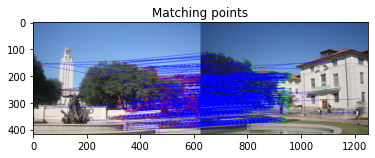

In [18]:
matching_yes=display_matches(image_left,image_right,matched)

In [19]:
#cv2.imwrite('matching_points.png',matching_yes)

In [20]:
#cv2.imwrite('deneme.png',image_left)

In [21]:
homo_ransac=ransac_func(matched)

In [22]:
blended=blend_img(image_left,image_right,homo_ransac)

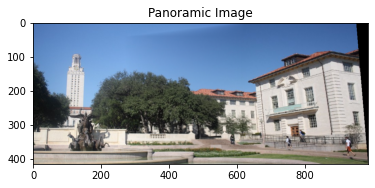

In [23]:
plt.figure(40)
plt.title("Panoramic Image")
plt.imshow(blended[:,:,::-1].astype(int))

In [24]:
cv2.imwrite('output.png',blended)

True